OBS: No Roboflow ao misturar Retangulos e Poligonos, se exportar como Yolov8 pode apresentar erros, por isso farei manualmente a conversão de COCOMM para Yolo


# 1. Imports

In [3]:
import os
import json
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.patches import Rectangle
import sys
import torch
import torchvision
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import CocoDetection
from torch.cuda.amp import autocast, GradScaler
from datetime import datetime
import onnx
import onnxruntime as ort
from PIL import Image
import numpy as np


base_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
print(base_dir)

sys.path.append(base_dir)

%matplotlib inline

/home/mdb/ProjetosPython/Picos


# 2.Load

In [4]:
base_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))

# Diretório onde estão as imagens e as anotações
images_dir = r'data/inputs/train_images/COCO_gx/train'  
annotations_path = r'data/inputs/train_images/COCO_gx/train/_annotations.coco.json'  

# Carregar anotações COCO
with open(os.path.join(base_dir, annotations_path)) as f:
    coco_data = json.load(f)

# Criar um dicionário para mapear IDs de imagens para anotações
annotations_dict = {}
for annotation in coco_data['annotations']:
    image_id = annotation['image_id']
    if image_id not in annotations_dict:
        annotations_dict[image_id] = []
    annotations_dict[image_id].append(annotation)
images_dict = {image['id']: image['file_name'] for image in coco_data['images']}

list(images_dict.items())[:5]  # Pega as 5 primeiras entradas

[(0, 'frame_0044_jpg.rf.9f563234bb1f9ace9b6893066bb5c227.jpg'),
 (1, 'frame_0015_jpg.rf.80e572edebef7f494fcccc171c2419b4.jpg'),
 (2, 'frame_0008_jpg.rf.943382d540b68463bd04781c5b892cbb.jpg'),
 (3, 'frame_0015_jpg.rf.b5684bb897b85228e7c4a8e449e04a16.jpg'),
 (4, 'frame_0008_jpg.rf.ff8f9d5549dad6ffc38a79cd93a32544.jpg')]

# 3. Test Images

## 3.2 Single annotation

Exibindo imagem: frame_0015_jpg.rf.308d6e84856b9ad0284029eea0320c13.jpg
Dimensões da imagem: 640x640 (largura x altura, 3 canais)
Coordenadas da bounding box: x=42, y=28, width=10.5, height=120.5


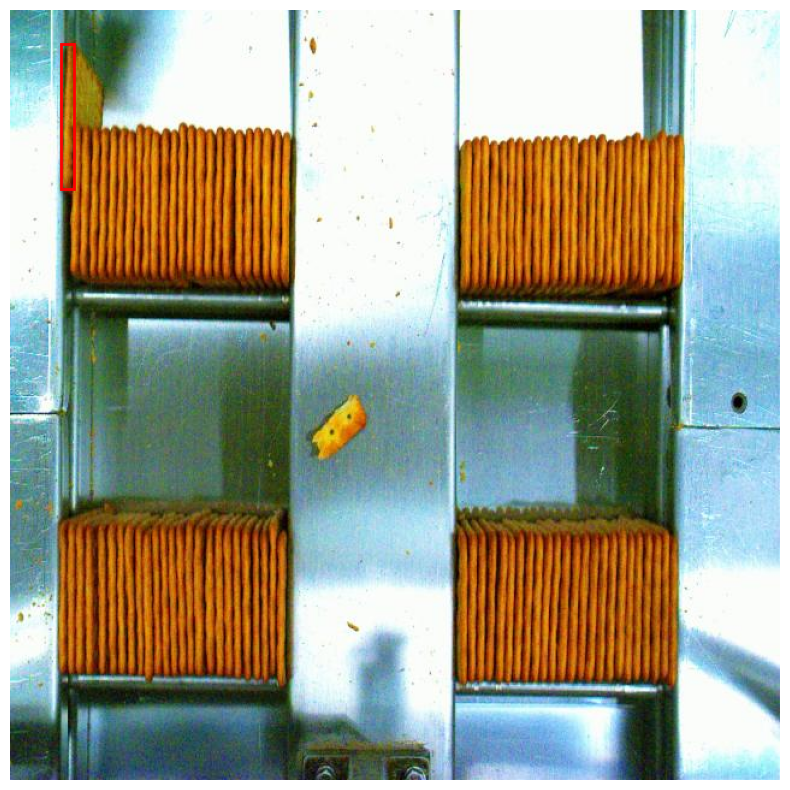

In [5]:
base_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))

# Função para carregar e visualizar imagens com uma anotação COCO específica
def visualize_coco_single_annotation(image_path, annotations, image_name, annotation_index):
    # Carregar a imagem
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Converter BGR para RGB
    
    # Exibir o nome da imagem e as dimensões
    height, width, channels = image.shape
    print(f"Exibindo imagem: {image_name}")
    print(f"Dimensões da imagem: {width}x{height} (largura x altura, {channels} canais)")
    
    # Criar uma figura para a imagem
    plt.figure(figsize=(10, 10))
    plt.imshow(image)

    # Carregar apenas a anotação escolhida
    if 0 <= annotation_index < len(annotations):
        annotation = annotations[annotation_index]
        x, y, w, h = annotation['bbox']  # bbox: [x, y, width, height]
        
        # Criar um retângulo para a caixa delimitadora
        rect = Rectangle((x, y), w, h, linewidth=2, edgecolor='r', facecolor='none')
        plt.gca().add_patch(rect)
        
        # Imprimir as coordenadas da bounding box
        print(f"Coordenadas da bounding box: x={x}, y={y}, width={w}, height={h}")
    else:
        print(f"Índice de anotação {annotation_index} não é válido. Existem apenas {len(annotations)} anotações.")

    plt.axis('off')  # Remover eixos
    plt.show()  # Exibir a imagem com a marcação

# Solicitar ao usuário para escolher uma imagem e uma anotação
image_choice = 15  # Escolher a imagem (ajuste conforme necessário)
annotation_choice = 0  # Escolher a anotação (ajuste conforme necessário)

# Verificar se a escolha da imagem é válida
if 0 <= image_choice < len(coco_data['images']):
    image_info = coco_data['images'][image_choice]
    image_file = image_info['file_name']
    image_path = os.path.join(base_dir, images_dir, image_file)
    image_id = image_info['id']
    
    # Obter anotações para a imagem selecionada
    annotations = annotations_dict.get(image_id, [])
    
    # Visualizar a imagem com a anotação específica
    visualize_coco_single_annotation(image_path, annotations, image_file, annotation_choice)
else:
    print("Escolha inválida!")


## 3.2 All annotations

Exibindo imagem: frame_0015_jpg.rf.308d6e84856b9ad0284029eea0320c13.jpg
Dimensões da imagem: 640x640 (largura x altura, 3 canais)
Coordenadas da bounding box: x=42, y=28, width=10.5, height=120.5
Coordenadas da bounding box: x=50, y=94, width=9, height=126
Coordenadas da bounding box: x=57, y=97, width=9, height=124.5
Coordenadas da bounding box: x=66, y=98, width=9, height=126.5
Coordenadas da bounding box: x=73, y=99, width=8.5, height=125
Coordenadas da bounding box: x=81, y=97, width=7.5, height=128
Coordenadas da bounding box: x=88, y=98, width=8, height=125.5
Coordenadas da bounding box: x=95, y=100, width=9, height=122.5
Coordenadas da bounding box: x=103, y=95, width=8, height=127
Coordenadas da bounding box: x=110, y=98, width=8, height=125
Coordenadas da bounding box: x=117, y=101, width=7.5, height=120
Coordenadas da bounding box: x=124, y=99, width=8, height=125.5
Coordenadas da bounding box: x=132, y=100, width=8.5, height=122.5
Coordenadas da bounding box: x=138, y=93, wi

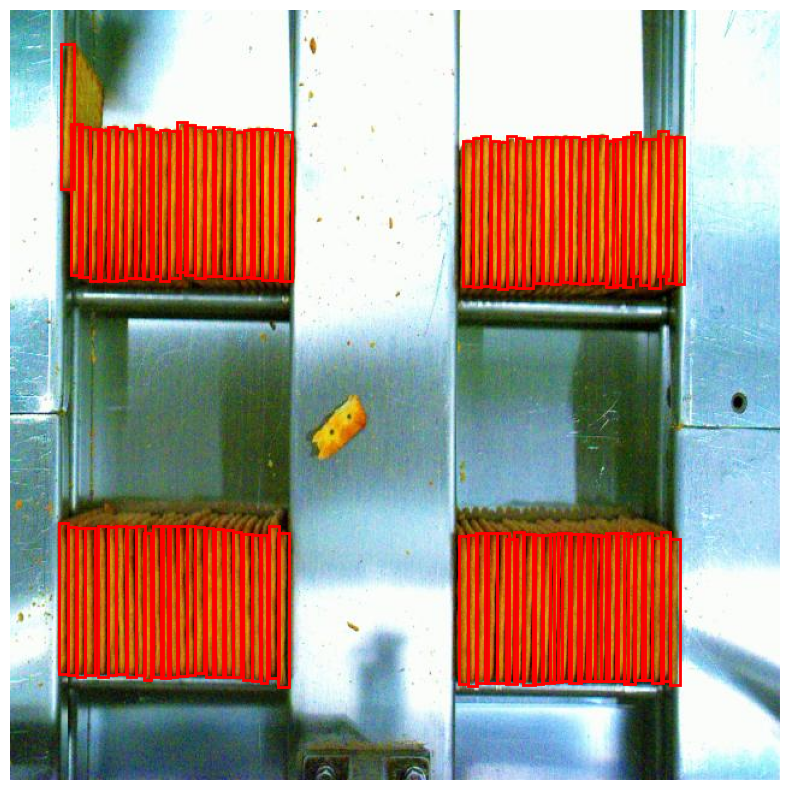

In [6]:
base_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))

# Função para carregar e visualizar todas as anotações de uma imagem COCO
def visualize_coco_all_annotations(image_path, annotations, image_name):
    # Carregar a imagem
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Converter BGR para RGB
    
    # Exibir o nome da imagem e as dimensões
    height, width, channels = image.shape
    print(f"Exibindo imagem: {image_name}")
    print(f"Dimensões da imagem: {width}x{height} (largura x altura, {channels} canais)")
    
    # Criar uma figura para a imagem
    plt.figure(figsize=(10, 10))
    plt.imshow(image)

    # Iterar sobre todas as anotações e desenhar as caixas delimitadoras
    for annotation in annotations:
        x, y, w, h = annotation['bbox']  # bbox: [x, y, width, height]
        
        # Criar um retângulo para a caixa delimitadora
        rect = Rectangle((x, y), w, h, linewidth=2, edgecolor='r', facecolor='none')
        plt.gca().add_patch(rect)
        
        # Imprimir as coordenadas da bounding box
        print(f"Coordenadas da bounding box: x={x}, y={y}, width={w}, height={h}")

    plt.axis('off')  # Remover eixos
    plt.show()  # Exibir a imagem com as marcações

# Solicitar ao usuário para escolher uma imagem
image_choice = 15  # Escolher a imagem (ajuste conforme necessário)

# Verificar se a escolha da imagem é válida
if 0 <= image_choice < len(coco_data['images']):
    image_info = coco_data['images'][image_choice]
    image_file = image_info['file_name']
    image_path = os.path.join(base_dir, images_dir, image_file)
    image_id = image_info['id']
    
    # Obter anotações para a imagem selecionada
    annotations = annotations_dict.get(image_id, [])
    
    # Visualizar a imagem com todas as anotações
    visualize_coco_all_annotations(image_path, annotations, image_file)
else:
    print("Escolha inválida!")


# 4. Train Models


## 4.1 Funcoes

In [7]:
# Iniciar
base_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # Definir o dispositivo (GPU ou CPU)

class CustomTransform: # Transformação das imagens
    def __call__(self, img, target):
        if isinstance(img, torch.Tensor):
            return img.to(device), target  # Verifica se a imagem é tensor, caso seja já envia para o dispositivo

        img = transforms.ToTensor()(img)  # Caso não seja Tensor, transforma em tensor
        return img.to(device), target  # Envia a imagem para o dispositivo
    
class CustomDataset(CocoDetection): # Configuração do dataset personalizado
    def __init__(self, root, annotation, transforms=None):
        super().__init__(root, annotation)
        self.transforms = transforms

    def __getitem__(self, idx):
        img, target = super().__getitem__(idx)

        if self.transforms:
            img, target = self.transforms(img, target)  # Aplica a transformação na imagem e no target

        return img, target
    
def create_model(weights, num_classes):
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights=weights)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(in_features, num_classes)

    return model

def load_pretrained_model(device, model, pretrained_model_path):
    if pretrained_model_path and os.path.exists(pretrained_model_path):
        model.load_state_dict(torch.load(pretrained_model_path, map_location=device))
        print(f"Modelo carregado de: {pretrained_model_path}")

    else:
        print("Treinando modelo do zero...")

    model.to(device)
    return model

def dataset_config(images_dir, annotations_path, data_loader_batch_size):
    dataset = CustomDataset(
        root=os.path.join(base_dir, images_dir),
        annotation=os.path.join(base_dir, annotations_path),
        transforms=CustomTransform()  # Passa a transformação customizada
    )

    # Configuração do DataLoader
    data_loader = DataLoader(dataset, batch_size=data_loader_batch_size, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))

    return dataset, data_loader

def run_train(device, model, data_loader, optimizer, num_epochs, save_path):
    best_loss = float('inf')  # Inicializa como infinito
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        total_boxes = 0  # Inicializa o contador de caixas
        for images, targets in data_loader:
            # Envie imagens para o dispositivo
            images = [image.to(device) for image in images]  # As imagens já são tensores

            # Processamento dos targets
            processed_targets = []
            for t in targets:
                boxes = []
                labels = []
                for annotation in t:
                    if 'bbox' in annotation and 'category_id' in annotation:  # Verifica se os campos existem
                        bbox = annotation['bbox']  # COCO: [x_min, y_min, width, height]
                        # Converte para [x_min, y_min, x_max, y_max]
                        x_min = bbox[0]
                        y_min = bbox[1]
                        width = bbox[2]
                        height = bbox[3]
                        x_max = x_min + width
                        y_max = y_min + height

                        boxes.append([x_min, y_min, x_max, y_max])
                        labels.append(annotation['category_id'])  # Adiciona o rótulo

                if boxes:  # Se houver caixas, processa
                    boxes_tensor = torch.tensor(boxes, dtype=torch.float32, device=device)  # Converte para tensor
                    labels_tensor = torch.tensor(labels, dtype=torch.int64, device=device)  # Converte para tensor

                    processed_targets.append({'boxes': boxes_tensor, 'labels': labels_tensor})
                    total_boxes += len(boxes_tensor)  # Incrementa o contador de caixas
                else:  # Para imagens sem anotações
                    processed_targets.append({
                        'boxes': torch.empty((0, 4), device=device),
                        'labels': torch.empty((0,), dtype=torch.int64, device=device)
                    })

            # Calcule a perda somente se houver caixas em algum dos targets
            if any(len(pt['boxes']) > 0 for pt in processed_targets):
                loss_dict = model(images, processed_targets)
                losses = sum(loss for loss in loss_dict.values())
                total_loss += losses.item()

                # Backpropagation
                optimizer.zero_grad()
                losses.backward()
                optimizer.step()

        average_loss = total_loss / len(data_loader)
        print(f"Epoch {epoch + 1}, Loss: {average_loss:.4f}, Total Boxes: {total_boxes}")

        # Se o loss for menor que o melhor loss, salve o modelo
        if average_loss < best_loss:
            best_loss = average_loss
            torch.save(model.state_dict(), save_path)
            print(f"Modelo salvo em: {save_path}")

def load_model_eval(device, model, pretrained_model_path):  # Colocar o modelo em modo de avaliação
    model.load_state_dict(torch.load(pretrained_model_path))
    model.to(device)
    model.eval() 

    return model


def load_image_tensor(image_path):
    image = Image.open(image_path).convert("RGB")  # Carrega a imagem e converte para RGB
    transform = transforms.ToTensor()  # Define a transformação para ToTensor
    image_tensor = transform(image).unsqueeze(0)  # Converte a imagem para tensor e adiciona uma dimensão de batch
    
    return image_tensor

def visualize_predictions_image(device, model, image_tensor, threshold=0.5):
    with torch.no_grad():  # Desativar cálculo de gradientes para economizar memória
        image_tensor = image_tensor.to(device)  # Enviar imagem para o dispositivo
        predictions = model(image_tensor)  # Fazer previsões

    prediction = predictions[0]

    image = image_tensor.squeeze(0).permute(1, 2, 0).cpu().numpy()  # Transpor a imagem para (H, W, C)

    # Criar figura com duas subplots
    fig, ax = plt.subplots(1, 2, figsize=(16, 8))

    # Exibir imagem original (sem marcações)
    ax[0].imshow(image)
    ax[0].axis('off')
    ax[0].set_title('Imagem Original', fontsize=16)

    # Exibir imagem com marcações
    ax[1].imshow(image)
    boxes = prediction['boxes'].cpu().detach().numpy()
    scores = prediction['scores'].cpu().detach().numpy()

    # Desenhar caixas delimitadoras
    for box, score in zip(boxes, scores):
        if score > threshold:  # Filtrar por pontuação
            x_min, y_min, x_max, y_max = box
            rect = patches.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min,
                                     linewidth=2, edgecolor='r', facecolor='none')
            ax[1].add_patch(rect)

    # Exibir o número total de detecções no topo da imagem com marcações
    detections = (scores > threshold).sum()  # Contar detecções acima do limite
    ax[1].set_title(f'Detecções Totais: {detections}', fontsize=16)
    ax[1].axis('off')

    plt.show()

def load_onnx_model(device, model_onnx_path):
    onnx_model = onnx.load(model_onnx_path)
    onnx.checker.check_model(onnx_model) # Verificar se o modelo é válido
    print("Modelo ONNX é válido!")
    
    providers = ['CUDAExecutionProvider', 'CPUExecutionProvider'] if device == "cuda" else ['CPUExecutionProvider'] # Configuração do provedor (CUDA ou CPU)
    ort_session = ort.InferenceSession(model_onnx_path, providers=providers) # Carregar o modelo ONNX com o provedor desejado
    
    return ort_session

def visualize_predictions_onnx(device, ort_session, image_tensor, threshold=0.5):
    image_tensor_device = image_tensor.to(device) # Enviar a imagem para o dispositivo (GPU ou CPU)
    
    input_name = ort_session.get_inputs()[0].name
    outputs = ort_session.run(None, {input_name: image_tensor_device.cpu().numpy()})
    
    print("Inferência ONNX concluída com sucesso!")
    
    # Carregar imagem
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Extrair as saídas do modelo ONNX
    boxes, labels, scores = outputs  # Ajuste aqui se os índices forem diferentes

    # Converter para numpy array
    boxes = np.array(boxes)
    labels = np.array(labels)
    scores = np.array(scores)

    # Filtrar as detecções pelo threshold
    for box, label, score in zip(boxes, labels, scores):
        if score >= threshold:
            x1, y1, x2, y2 = map(int, box)  # Coordenadas da caixa
            cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)
            text = f"Classe {label} ({score:.2f})"
            cv2.putText(image, text, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

    # Exibir a imagem com as predições
    plt.figure(figsize=(8, 8))
    plt.imshow(image)
    plt.axis("off")
    plt.show()



## 4.2 Faster RCNN

### 4.2.1 FP32 (Padrão)

In [ ]:
# Iniciar
base_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # Definir o dispositivo (GPU ou CPU)

# Inputs
images_dir = r'data/inputs/train_images/COCO_gx/train' 
annotations_path = r'data/inputs/train_images/COCO_gx/train/_annotations.coco.json' 
save_dir = os.path.join(base_dir, 'data', 'inputs', 'ia_models', 'FRCNN Resnet50')
models_path = os.path.join(base_dir, 'data', 'inputs', 'ia_models', 'FRCNN Resnet50')
pretrained_model_path = os.path.join(models_path, 'best_faster_rcnn_model_20250326_154439.pth')  # Altere para o caminho do modelo salvo (ex: 'caminho/para/modelo.pth') ou mantenha None para treinar do zero
weights='FasterRCNN_ResNet50_FPN_Weights.COCO_V1'
num_classes = 2  # Inclua o número de classes (background + classes)
data_loader_batch_size = 8
num_epochs = 10000

# Main
model = create_model(weights, num_classes)
model = load_pretrained_model(device, model, pretrained_model_path)
dataset, data_loader = dataset_config(images_dir, annotations_path, data_loader_batch_size)

optimizer = torch.optim.SGD(model.parameters(), lr=1e-4, momentum=0.9, weight_decay=0.0005) # Defina o otimizador

print(f"Modelo está sendo treinado no dispositivo: {next(model.parameters()).device}") # Verificar se o modelo está no dispositivo correto (GPU ou CPU)

timestamp = datetime.now().strftime('%Y%m%d_%H%M%S') # Obter o timestamp atual para nomear o modelo
save_path = os.path.join(save_dir,  f'best_faster_rcnn_model_{timestamp}.pth')

run_train(device, model, data_loader, optimizer, num_epochs, save_path)

Modelo carregado de: /home/mdb/ProjetosPython/Picos_pip/data/inputs/ia_models/FRCNN Resnet50/best_faster_rcnn_model_20250326_154439.pth
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Modelo está sendo treinado no dispositivo: cuda:0
Epoch 1, Loss: 0.2201, Total Boxes: 1029
Modelo salvo em: /home/mdb/ProjetosPython/Picos_pip/data/inputs/ia_models/FRCNN Resnet50/best_faster_rcnn_model_20250327_090827.pth


KeyboardInterrupt: 

### 4.2.2 Test Model

Modelo carregado de: /home/mdb/ProjetosPython/Picos_pip/data/inputs/ia_models/FRCNN Resnet50/best_faster_rcnn_model_20241203.pth
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Modelo no modo de avaliação no dispositivo: cuda:0


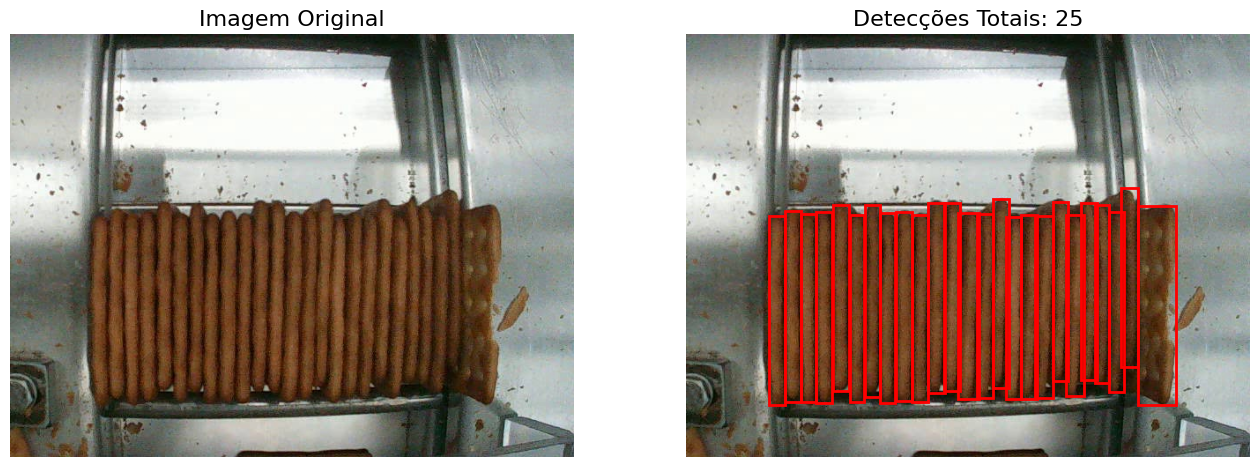

In [ ]:
# Iniciar
base_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # Definir o dispositivo (GPU ou CPU)

# Inputs
images_dir = r'data/inputs/train_images/COCO/train' 
annotations_path = r'data/inputs/train_images/COCO/train/_annotations.coco.json' 
save_dir = os.path.join(base_dir, 'data', 'inputs', 'ia_models', 'FRCNN Resnet50')
models_path = os.path.join(base_dir, 'data', 'inputs', 'ia_models', 'FRCNN Resnet50')
pretrained_model_path = os.path.join(models_path, 'best_faster_rcnn_model_20250326_154439.pth')  # Altere para o caminho do modelo salvo (ex: 'caminho/para/modelo.pth') ou mantenha None para treinar do zero
weights='FasterRCNN_ResNet50_FPN_Weights.COCO_V1'
num_classes = 2  # Inclua o número de classes (background + classes)
num_epochs = 10000
data_loader_batch_size = 1

#  Main
model = create_model(weights, num_classes)
model = load_pretrained_model(device, model, pretrained_model_path)
model = load_model_eval(device, model, pretrained_model_path)
test_dataset, test_data_loader = dataset_config(images_dir, annotations_path, data_loader_batch_size)

print(f"Modelo no modo de avaliação no dispositivo: {next(model.parameters()).device}") # Verificar se o modelo está no dispositivo correto (GPU ou CPU)

# Caminho da imagem que você deseja testar
image_path = r'/home/mdb/ProjetosPython/Picos_pip/data/inputs/test_images/Imagem0001 - 25.jpg'  # Substitua pelo caminho da sua imagem
image_tensor = load_image_tensor(image_path)

visualize_predictions_image(device, model, image_tensor, threshold=0.5)

## 4.3 ONNX

### 4.3.1 Convert to ONNX

In [4]:
# Iniciar
base_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # Definir o dispositivo (GPU ou CPU)

# Inputs
images_dir = os.path.join(base_dir, r'data/inputs/train_images/COCO/train') 
annotations_path =  r'data/inputs/train_images/COCO/train/_annotations.coco.json'
save_dir = os.path.join(base_dir, 'data', 'inputs', 'ia_models', 'FRCNN Resnet50')
models_path = os.path.join(base_dir, 'data', 'inputs', 'ia_models', 'FRCNN Resnet50')
pretrained_model_path = os.path.join(models_path, 'best_faster_rcnn_model_20250326_154439.pth')  # Altere para o caminho do modelo salvo (ex: 'caminho/para/modelo.pth') ou mantenha None para treinar do zero
weights='FasterRCNN_ResNet50_FPN_Weights.COCO_V1'
num_classes = 2  # Inclua o número de classes (background + classes)
data_loader_batch_size = 8
num_epochs = 10000

model = create_model(weights, num_classes)
model = load_pretrained_model(device, model, pretrained_model_path)
model = load_model_eval(device, model, pretrained_model_path)
dataset, data_loader = dataset_config(images_dir, annotations_path, data_loader_batch_size)

dummy_input = torch.randn(1, 3, 640, 640, device=device) # Criar um tensor de entrada simulado (1 imagem com 3 canais, 640x640)

model_onnx_path = os.path.join(models_path,  f'{os.path.splitext(os.path.basename(pretrained_model_path))[0]}.onnx') # Nome do arquivo ONNX

# Exportar o modelo para ONNX
torch.onnx.export(
    model,                          # Modelo treinado
    dummy_input,                    # Entrada simulada
    model_onnx_path,                       # Nome do arquivo de saída
    opset_version=11,                # Versão do conjunto de operações ONNX
    input_names=["input"],           # Nome da entrada
    output_names=["boxes", "labels", "scores"],  # Nomes das saídas
    dynamic_axes={"input": {0: "batch_size"},   # Permite entradas de diferentes tamanhos
                  "boxes": {0: "batch_size"},
                  "labels": {0: "batch_size"},
                  "scores": {0: "batch_size"}}
)

print(f"Modelo convertido para ONNX e salvo como '{model_onnx_path}'.")

Modelo carregado de: /home/mdb/ProjetosPython/Picos_pip/data/inputs/ia_models/FRCNN Resnet50/best_faster_rcnn_model_20250326_154439.pth
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


/home/mdb/ProjetosPython/Picos_pip/.venv/lib/python3.8/site-packages/torch/nn/functional.py:3948: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  (torch.floor((input.size(i + 2).float() * torch.tensor(scale_factors[i], dtype=torch.float32)).float()))
/home/mdb/ProjetosPython/Picos_pip/.venv/lib/python3.8/site-packages/torchvision/ops/boxes.py:157: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes_x = torch.min(boxes_x, torch.tensor(width, dtype=boxes.dtype, device=boxes.device))
/home/mdb/ProjetosPython/Picos_pip/.venv/lib/python3.8/site-packages/torchvision/ops/boxes.py:159: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTen

====== Diagnostic Run torch.onnx.export version 2.1.0a0+41361538.nv23.06 =======
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================

Modelo convertido para ONNX e salvo como '/home/mdb/ProjetosPython/Picos_pip/data/inputs/ia_models/FRCNN Resnet50/best_faster_rcnn_model_20250326_154439.onnx'.


### 4.3.2 Test Model

Modelo ONNX é válido!
Inferência ONNX concluída com sucesso!


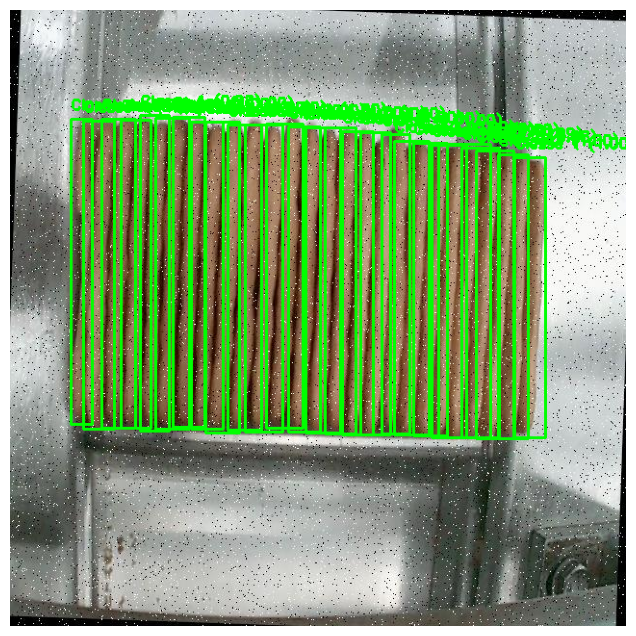

In [5]:
# Iniciar
base_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # Definir o dispositivo (GPU ou CPU)

# Inputs
images_dir = os.path.join(base_dir, r'data/inputs/train_images/COCO/train') 
annotations_path =  r'data/inputs/train_images/COCO/train/_annotations.coco.json'
save_dir = os.path.join(base_dir, 'data', 'inputs', 'ia_models', 'FRCNN Resnet50')
models_path = os.path.join(base_dir, 'data', 'inputs', 'ia_models', 'FRCNN Resnet50')
model_onnx_path = os.path.join(models_path, 'best_faster_rcnn_model_20250326_154439.onnx')  # Altere para o caminho do modelo salvo (ex: 'caminho/para/modelo.pth') ou mantenha None para treinar do zero
weights='FasterRCNN_ResNet50_FPN_Weights.COCO_V1'
num_classes = 2  # Inclua o número de classes (background + classes)
data_loader_batch_size = 8
num_epochs = 10000

jpg_files = [f for f in os.listdir(images_dir) if f.lower().endswith('.jpg')]
image_path = os.path.join(images_dir, jpg_files[0]) # Primeira Imagem
image_tensor = load_image_tensor(image_path)
ort_session = load_onnx_model(device, model_onnx_path)
outputs = visualize_predictions_onnx(device, ort_session, image_tensor, threshold=0.5)

# 4.4 Convert to TensorRT

In [6]:
# Inputs
images_dir = os.path.join(base_dir, r'data/inputs/train_images/COCO/train') 
annotations_path =  r'data/inputs/train_images/COCO/train/_annotations.coco.json'
save_dir = os.path.join(base_dir, 'data', 'inputs', 'ia_models', 'FRCNN Resnet50')
models_path = os.path.join(base_dir, 'data', 'inputs', 'ia_models', 'FRCNN Resnet50')
model_model_onnx_path = os.path.join(models_path, 'best_faster_rcnn_model_20250326_154439.onnx')  # Altere para o caminho do modelo salvo (ex: 'caminho/para/modelo.pth') ou mantenha None para treinar do zero
weights='FasterRCNN_ResNet50_FPN_Weights.COCO_V1'
num_classes = 2  # Inclua o número de classes (background + classes)
data_loader_batch_size = 8
num_epochs = 10000


# Carregar o modelo ONNX
onnx_model = onnx.load(model_onnx_path)

# Verificar se há erros
onnx.checker.check_model(onnx_model)
print("Modelo ONNX é válido!")

# Testar inferência com ONNX Runtime
ort_session = ort.InferenceSession(model_onnx_path)
outputs = ort_session.run(None, {"input": dummy_input.cpu().numpy()})

print("Inferência ONNX concluída com sucesso!")

# Converter ONNX para TensorRT
TRT_LOGGER = trt.Logger(trt.Logger.WARNING)
builder = trt.Builder(TRT_LOGGER)
network = builder.create_network(1)
parser = trt.OnnxParser(network, TRT_LOGGER)

with open(model_onnx_path, 'rb') as model_file:
    if not parser.parse(model_file.read()):
        print("Falha ao analisar o modelo ONNX!")
        for error in range(parser.num_errors):
            print(parser.get_error(error))
        exit()

config = builder.create_builder_config()
config.max_workspace_size = 1 << 30  # 1GB
engine = builder.build_engine(network, config)

# Salvar o modelo TensorRT
trt_engine_path = "faster_rcnn_resnet50.trt"
with open(trt_engine_path, "wb") as f:
    f.write(engine.serialize())

print(f"Modelo convertido para TensorRT e salvo como '{trt_engine_path}'.")

Modelo ONNX é válido!


ValueError: This ORT build has ['TensorrtExecutionProvider', 'CUDAExecutionProvider', 'CPUExecutionProvider'] enabled. Since ORT 1.9, you are required to explicitly set the providers parameter when instantiating InferenceSession. For example, onnxruntime.InferenceSession(..., providers=['TensorrtExecutionProvider', 'CUDAExecutionProvider', 'CPUExecutionProvider'], ...)